# Competição do kaggle sem aumentar o dataset e sem preencher dados faltantes

## Imports

In [1]:
import torch as tc
import torch
import torchvision
from torchvision import models,transforms
from torch import nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import Utils as utils
from torch.optim.lr_scheduler import StepLR
import copy
from copy import deepcopy

import math

In [2]:
from sklearn import linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import os,sys,time
import torch.optim as optim
from PIL import Image
%matplotlib inline

In [267]:
def plot_losses(loss_history,best_epoch_loss,val_history=None):
    #plt.rcParams.update({'font.size': 16})

    fig = plt.figure(figsize=(20,7))
    if val_history is None:

        ax = fig.add_subplot(1,1,1)
    else:
        ax = fig.add_subplot(1,2,1)
        
    ax = fig.add_axes
    plt.plot(np.arange(best_epoch_loss),loss_history.numpy()[:best_epoch_loss],'-o')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Loss function trajectory in training set')
    #plt.xlim((0.0001,0.0009))  
    if isinstance(val_history,torch.Tensor):
        plt.subplot(1,2,2)
        plt.plot(np.arange(best_epoch_loss),val_history.numpy()[:best_epoch_loss],'-o',color = 'red')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.title('Loss function trajectory in validation set')


In [196]:
def train_network(model, data_loader_train, epochs, loss_fn, optimizer, patience=5, data_loader_validation=None):
    loss_history = torch.zeros(epochs)
    gpu_available = True
    if data_loader_validation:
        loss_history_val = torch.zeros(epochs)
        best_val_loss = 1e10
        best_loss_epoch = 0
        patience_counter = 0
        best_model = None
    
    for epoch in range(epochs):
        loss_sum = 0
        if epoch % 20 == 0:
            print('Starting epoch # {}'.format(epoch+1))
        for i, data in enumerate(data_loader_train):
       #     print('starting batch # {}'.format(i+1), end='\r')
            inp, target = data
            if gpu_available:
                inp, target = inp.cuda(), target.cuda()
            inp, target = Variable(inp), Variable(target)
            
            optimizer.zero_grad()
            output = model(inp)
            loss = loss_fn(output, target)
            loss_sum += loss.data[0]

            loss.backward()
            optimizer.step()

        loss_history[epoch] = loss_sum / len(data_loader_train)
        
        # If there is a validation set, perform validation for all batches in 
        if data_loader_validation:
            model.eval()
            loss_sum_val = 0
            for i, data in enumerate(data_loader_validation):
                inp, target = data
                if gpu_available:
                    inp, target = inp.cuda(), target.cuda()
                inp, target = Variable(inp), Variable(target)
                output = model(inp)
                loss_val = loss_fn(output, target)
                loss_sum_val += loss_val.data[0]
                
            model.train()
            loss_history_val[epoch] = loss_sum_val / len(data_loader_validation)
            
            if loss_history_val[epoch] < best_val_loss:
                best_val_loss = loss_history_val[epoch]
                best_model = deepcopy(model)
                best_loss_epoch = epoch
                patience_counter = 0
                
            else:
                patience_counter += 1
                if patience_counter > patience:
                    model = best_model
                    print("[INFO] Early stopping in epoch {}.".format(epoch+1))
                    print("Using model with val loss = {}.".format(best_val_loss+1))
                    break
        
        #print('\n')
        
    if data_loader_validation is None:
        return model, loss_history,epoch
    else:
        return model, loss_history, loss_history_val,best_loss_epoch

In [3]:
def un_normalize(target):
    target = (target*48)+48
    return target

In [4]:
def show_images(X,target):
    plt.figure(figsize=(20, 4))
    #create random 10 ints in the X_train.shape
    random_array = np.random.randint((X.shape[0]-1),size=5)

    for k,i in enumerate(random_array):
        plt.subplot(1,5,k + 1)
        
        for z in range(0,target.shape[1],2):
            #print('i', i)
            plt.scatter(target[i,z],target[i,z+1],color = '#A3C208')
            plt.imshow(X[i],cmap='gray')
            
            

In [14]:
def load(path_train,path_test):
    #load the data in a pd.Dataframe
    data = pd.read_csv(path_train)
    
    #Separetes the values to create a numpy vector of imagges
    X_train = np.zeros(((len(data["Image"])),96,96))
    for i in range(len(data["Image"])):
        lista = np.asarray(data["Image"][i].split(' '))    
        np_lista = np.asarray(lista).reshape(96,96)
        X_train[i] = np_lista
    
    #Gets the values in the test set
    
    
    #Pega o valor de target:
    target = data.loc[:,'left_eye_center_x':'mouth_center_bottom_lip_y']
    target_null = target.notnull().all(1).as_matrix()
    idx = np.argwhere(target_null>0)
    idx = idx.reshape(idx.shape[0])
    target = target.iloc[idx].as_matrix()

    data_test = pd.read_csv(path_test)
    X_test = np.zeros(((len(data_test["Image"])),96,96))
    for i in range(len(data_test["Image"])):
        lista = data_test.iloc[i,1].split(" ")
        np_lista = np.asarray(lista).reshape(96,96)
        X_test[i] = np_lista

    
    #Xtrain sem nuloes
    X_train = X_train[idx]

    return(X_train, X_test, target)

In [15]:

def normalize2(X, target=None, image_size=96, channels=1):
    use_gpu = tc.cuda.is_available()

    X = X/255.
    
    if target is not None:
        if use_gpu == True:
            target.cuda()
            
        target =  tc.add(target, -48)
        target = tc.div(target,48)
    return(X,target)

In [16]:
def show_images(X_train,target):
    plt.figure(figsize=(20, 4))
    #create random 10 ints in the X_train.shape
    random_array = np.random.randint((X_train.shape[0]-1),size=5)
    
    for k,i in enumerate(random_array):
        plt.subplot(1,5,k + 1)
        
        for z in range(0,target.shape[1],2):
            plt.scatter(target[i,z],target[i,z+1],color = '#A3C208')
            plt.imshow(X_train[i].reshape(96,96),cmap='gray')

            

In [17]:
class data_loader(torch.utils.data.Dataset):

    def __init__(self,image_array, target, train=False, transform=transforms):
        """
        Args:
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.target = target
        self.images = image_array
        if train:
            #self.X_train = self.data['X_train']
            
            if use_gpu and not isinstance(target,tc.Tensor):
                self.target = tc.from_numpy(self.target).cuda()
            elif not use_gpu and not isinstance(target,tc.Tensor):
                self.target = tc.from_numpy(self.target)
        else:
            print()
        
    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.target[idx]
        target = target.float()
        if not isinstance(image,tc.Tensor):
            image = tc.from_numpy(image).cuda()
        image = image.resize_(1,96,96)
        image = image.float()
        return image,target

In [18]:
def our_split(X_train,X_test,Y_train,percentage):
    
    X_val = X_train[int(percentage*X_train.shape[0]):]
    Y_val = Y_train[int(percentage*Y_train.shape[0]):]
    X_train = X_train[:int(percentage*X_train.shape[0])]
    Y_train = Y_train[:int(percentage*Y_train.shape[0])]
    
    return(X_train,Y_train,X_val,Y_val) 
        

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 32, 3)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.drop1 = torch.nn.Dropout(0.25)
        
        self.conv3 = torch.nn.Conv2d(64, 48, 3)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.drop2 = torch.nn.Dropout(0.25)
        
        self.dense1 = torch.nn.Linear(48 * 22 * 22, 512)
        self.drop3 = torch.nn.Dropout(0.2)
        self.dense2 = torch.nn.Linear(512, 30)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = x.view(-1, 48 * 22 * 22)
        x = F.relu(self.dense1(x))
        x = self.drop3(x)
        x = self.dense2(x)
        return x

In [68]:
class Net(nn.Module):
    def __init__(self, image_size=(1,96,96)):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, 5, 1),
            nn.Dropout(0.5),
            nn.Conv2d(8, 16, 5, 1),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 5, 1),
            nn.Dropout(0.5),
            nn.Conv2d(32, 64, 5, 1),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 5, 1),
            nn.Dropout(0.5),        
        )
        self.n_conv_features = self._get_conv_output(image_size)
        self.fc = nn.Sequential(
            nn.Linear(self.n_conv_features, 200),
            nn.Linear(200, 100),
            nn.Linear(100, 30)
        )
        
    def _get_conv_output(self, shape):
        bs = 1
        input = Variable(torch.rand(bs, *shape))
        output_feat = self.conv(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, self.n_conv_features)
        x = self.fc(x)
        return x

In [123]:
 def fast_fit(data_loader, model, epochs, loss_fn, optimizer):
    use_gpu = torch.cuda.is_available()

    loss_history = torch.zeros(epochs)
    loss_sum = 0
    model.train()
    for epoch in range(epochs):
        loss_sum = 0
    
        for k,data in enumerate(data_loader):
          
             #   return model,loss_history
            inp, target = data

            if use_gpu:
                inp, target = Variable(inp).cuda(), Variable(target).cuda()
            else:
                inp, target = Variable(inp), Variable(target)
          
            #Zeros the gradients for each pass
            optimizer.zero_grad()

            #Make the predict (foward-pass) 
            output = model(inp)
          
            #Calculates the loss in the foward pass (in the "train" fase this will be back-propagated).

            loss = loss_fn(output, target)
            loss_sum += loss.data[0]
          

            loss.backward()
            optimizer.step()

        loss_history[epoch] = loss_sum / len(data_loader)
        if epoch % 20 == 0:
            print('epoch: {} loss: {}'.format(epoch, loss_history[epoch]))

    return model,loss_history


def dict_creator(train_loader,val_loader):
    new_dict = {}
    dict_sizes = {}
    new_dict['train'] = train_loader
    new_dict['val'] = val_loader
    dict_sizes['train'] = new_dict['train'].batch_size * len (new_dict['train'])
    dict_sizes['val'] = new_dict['val'].batch_size * len (new_dict['val'])

    return new_dict,dict_sizes

In [21]:
def evaluate(data_loader, model):


    use_gpu = tc.cuda.is_available()

    if use_gpu:
        model.cuda()
    else:
        model.cpu()
        
    #Take the number of features
    for k,i in enumerate(data_loader):
        if k > 0:
            break
        num_feat = i[1].size()[1]
    
    len_dataset = len(test_loader.dataset)
    if use_gpu:
        Y_test = tc.Tensor(0,num_feat).float().cuda()
        
    else:
        Y_test = tc.Tensor(0,num_feat).float()
        
    batch_size = data_loader.batch_size

    model.eval()
    for k,data in enumerate(data_loader):
     
        images, labels = data
        images = images
        images = Variable(images)
        if use_gpu:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
        else:
            outputs = model(images)

        Y_test = tc.cat((Y_test, outputs.data),0)
    model.train()
    return(Y_test)


# Começo do código

In [22]:
use_gpu = tc.cuda.is_available()
print(use_gpu)

True


## Pegando os dados

In [23]:
begin = time.time()
X_train, X_test, target = load('training.csv','test.csv')
end = time.time()
print("Time elapsed = ",end-begin,'.')

Time elapsed =  24.822774648666382 .


In [24]:
print((X_train.shape))
print((X_test.shape))      
print((target.shape))    

(2140, 96, 96)
(1783, 96, 96)
(2140, 30)


# Normalizando os dados

In [25]:
begin = time.time()
X_train_normalized,target_normalized = normalize2(tc.from_numpy(X_train).float(),tc.from_numpy(target).float())
X_test_normalized,_ = normalize2(tc.from_numpy(X_test).float(),tc.from_numpy(target).float())
print(X_train_normalized.shape)

end = time.time()
#Pode demorar se for a primeira vez a criar a estrutura .cuda()
print("Time elapsed",end-begin)

torch.Size([2140, 96, 96])
Time elapsed 1.3708209991455078


In [26]:
print("New std, must be one",X_train_normalized.std())
print("New mean, must be zero",X_train_normalized.mean())

print("New std, must be one",X_test_normalized.std())
print("New mean, must be zero",X_test_normalized.mean())


New std, must be one 0.2316481927529975
New mean, must be zero 0.4747574322888841
New std, must be one 0.23504152144180532
New mean, must be zero 0.4895310814687257


## Separando em conjunto de treino e validação

In [33]:

X_train_new,Y_train,X_val,Y_val = our_split(X_train_normalized, X_test_normalized,target_normalized, percentage=0.9)
print(X_train_new.shape,Y_train.shape,X_val.shape,Y_val.shape)

torch.Size([1926, 96, 96]) torch.Size([1926, 30]) torch.Size([214, 96, 96]) torch.Size([214, 30])


## Transformações

In [34]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Scale(256),
        transforms.ToTensor(),
    ])
}

## Criando os dataloaders

In [161]:
print(X_train_new.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

torch.Size([1926, 96, 96])
torch.Size([1926, 30])
torch.Size([214, 96, 96])
torch.Size([214, 30])


In [162]:
begin = time.time()
faces_dataset_train = data_loader(X_train_new,Y_train, train = True,transform = data_transforms['train'])
train_loader = tc.utils.data.DataLoader(faces_dataset_train, batch_size=64, shuffle=True)
end = time.time()

print("Elapsed time!",end-begin)

Elapsed time! 0.00028896331787109375


In [163]:

begin = time.time()
faces_dataset_val = data_loader(X_val, Y_val, train =  False ,transform = data_transforms['train'])
val_loader = tc.utils.data.DataLoader(faces_dataset_val, batch_size=64, shuffle=False)
end = time.time()

print("Elapsed time!",end-begin)


Elapsed time! 0.0004665851593017578


In [164]:
begin = time.time()
faces_dataset_test = data_loader(X_test_normalized,target_normalized[:X_test.shape[0]], train = False,transform = data_transforms['train'])
test_loader = tc.utils.data.DataLoader(faces_dataset_test, batch_size=20, shuffle=False)
end = time.time()
print("Elapsed time = ",end-begin,'!')



Elapsed time =  0.0001475811004638672 !


## Creating the models: net1


In [263]:
if 'model_net1' in globals():
    del model_net1

In [264]:
use_gpu=True
model_net1 = Net()

print(model_net1)
begin = time.time()
if (use_gpu==True):
    model_net1.cuda()
end = time.time()
print('Elapsed time = {0:.5f}s. '.format(end-begin))

Net (
  (conv): Sequential (
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout (p = 0.5)
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): Dropout (p = 0.5)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): Dropout (p = 0.5)
  )
  (fc): Sequential (
    (0): Linear (12544 -> 200)
    (1): Linear (200 -> 100)
    (2): Linear (100 -> 30)
  )
)
Elapsed time = 0.00402s. 


## Setando os parâmetros

In [265]:
if use_gpu:
    criterion = nn.MSELoss().cuda()
else:
    criterion = nn.MSELoss()
    
optimizer_ft = optim.Adam(model_net1.parameters(), lr=1e-4)
#optimizer_ft = optim.Adam(model_net1_will.parameters())
#optimizer_ft = optim.RMSprop(model_net1.parameters(), lr=1e-4)

# Treinando com minha função de treino

new_dict , dict_sizes = dict_creator(train_loader,val_loader)

model_net1,best_epoch = fit(model_net1,new_dict,dict_sizes,
                            criterion,optimizer = optimizer_ft,num_epochs=30,
                            scheduler=scheduler,patience=6,opt='loss')

## Função de treino

In [269]:
#Treinando sem early stop
#model, loss_history , best_epoch_loss = train_network(model_net1, train_loader,
       #                             epochs=200, loss_fn=criterion, optimizer=optimizer_ft,patience=20,
        #                            data_loader_validation=None)

#Treinando com early stop
model, loss_history , val_history,best_epoch_loss = train_network(model_net1, train_loader,
                                epochs=300, loss_fn=criterion, optimizer=optimizer_ft,patience=20,
                                data_loader_validation=val_loader)

    

Starting epoch # 1
Starting epoch # 21
Starting epoch # 41
Starting epoch # 61
Starting epoch # 81
Starting epoch # 101
Starting epoch # 121
Starting epoch # 141
Starting epoch # 161
Starting epoch # 181
Starting epoch # 201
Starting epoch # 221
Starting epoch # 241
Starting epoch # 261
Starting epoch # 281



model_net1,loss_history = fast_fit(train_loader,model_net1,epochs=120,loss_fn=criterion,optimizer=optimizer_ft)

## Plotando a loss

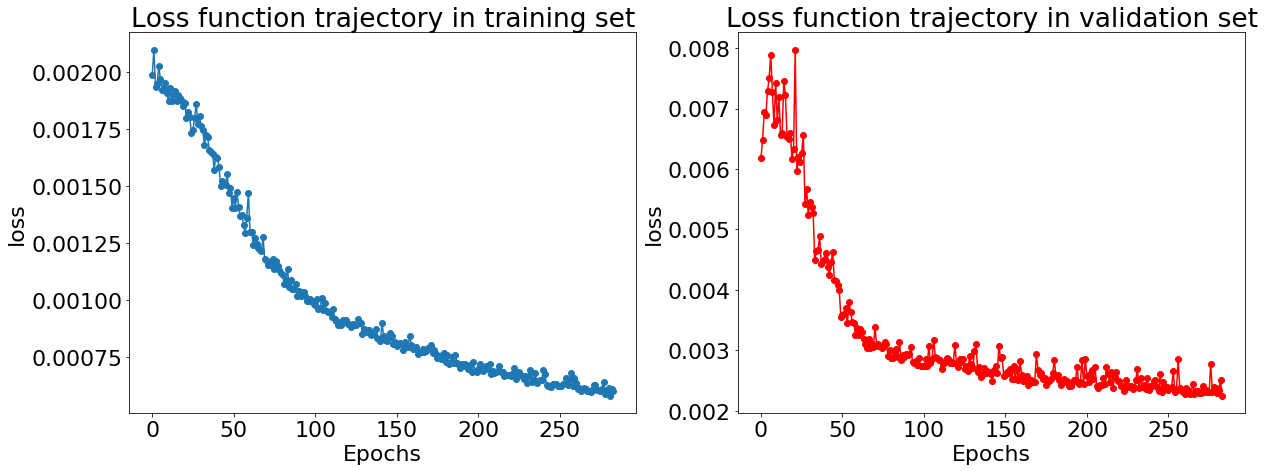

In [270]:
plot_losses(loss_history=loss_history, best_epoch_loss=best_epoch_loss, val_history=val_history)


## Criando as predições do conjunto X_test

In [271]:
begin = time.time()
Y_test = evaluate(test_loader,model_net1)
end = time.time()
print('Time elapsed = ',end-begin,"!")

Time elapsed =  0.21692895889282227 !


## Imagens do conjunto de treinamento (dados tageados)

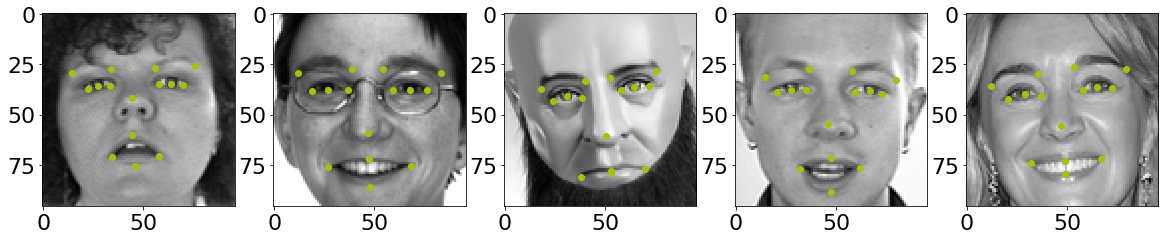

In [272]:
show_images(X_train,target)

## Dados Preditos

In [273]:
#Desnormalizando os dados (para fazer sentido no plot)
Y_test_un = un_normalize(Y_test)

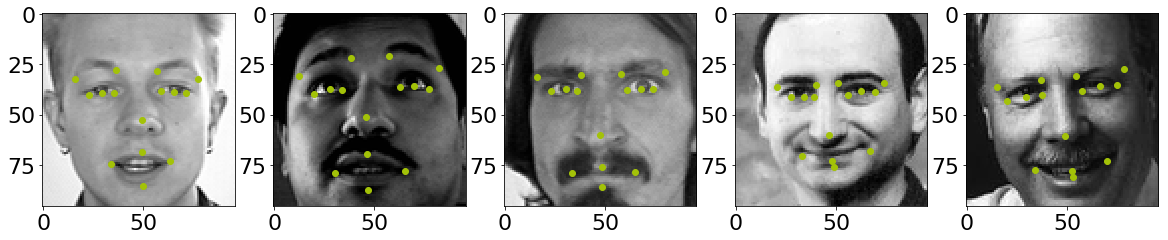

In [274]:
show_images(X_test,Y_test_un.cpu().numpy())